<a href="https://colab.research.google.com/github/yuja28/sw_Bootcamp/blob/main/VirginTrains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/customer-support-on-twitter/input/twcs/twcs.csv")
df.head()



,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [25]:
#회사 선택
print("어떤 회사의 지원을 원하시나요?")
company = input()

answers = df.loc[df['author_id'] == company]

df_text=df[['text']]
df_text.head()

df["text_lower"] = df["text"].str.lower()
df.head()

# 소문자 변환, 마침표 제거, 사용자 언급 부분 제거, 구두점 제거 함수 정의
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = text.rstrip('.')  # 문장 끝 마침표 제거
    text = re.sub("\B@\w+", "", text)  # 사용자 언급 부분 제거
    text = text.translate(str.maketrans('', '', string.punctuation))  # 구두점 제거
    return text

# 데이터 전처리 적용
answers['text_preprocessed'] = answers['text'].apply(preprocess_text)

# 상위 10개의 답변만 출력
print(answers['text_preprocessed'].head())

어떤 회사의 지원을 원하시나요?
VirginTrains
644     if youre unhappy with your experience on this...
646     youd need to contact our aftersales team on 0...
649     when amending a ticket the system would show ...
651     yes it does you need to select the return jou...
654     not at this stage sadly but the some lines wi...
Name: text_preprocessed, dtype: object


In [18]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('/content/drive/MyDrive/customer-support-on-twitter/input/sample.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'sample.csv'
nRow, nCol = df1.shape

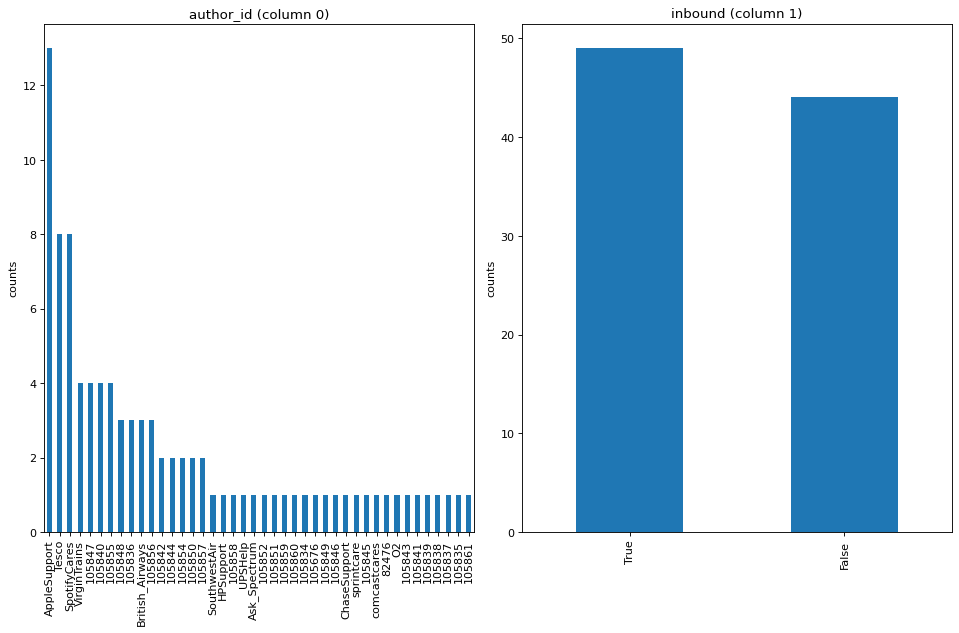

In [20]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Distribution graphs of sampled columns
plotPerColumnDistribution(df1,10, 5)

In [12]:
nltk.download('punkt')
nltk.download('wordnet')

#문장 토큰화
sentence_tokens = nltk.sent_tokenize(raw)
#단어 토큰화
word_tokens = nltk.word_tokenize(raw);

lemmer = nltk.stem.WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#사용자 입력에 대한 응답 처리 함수 정의
def response(user_response):
    #응답 변수 초기화
    robo_response=''
    #사용자 입력을 응답으로 추가
    sentence_tokens.append(user_response)
    #TF-IDF 벡터화기 생성
    vectorizer = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
    #토큰 처리
    diff = vectorizer.fit_transform(sentence_tokens)
    #코사인 유사도 계산
    vals = cosine_similarity(diff[-1], diff)
    #선택된 문장 인덱스
    idx = vals.argsort()[0][-2]
    #정확도 계산
    flat = vals.flatten()
    flat.sort()
    req_diff = flat[-2]
    if(req_diff==0):
        #적절한 응답이 없을 경우
        robo_response=robo_response+"죄송합니다! 해당 질문에 대해 도움을 드리기 어려운 것 같습니다."
        return robo_response
    else:
        #적절한 응답이 있을 경우
        robo_response = sentence_tokens[idx]
        return robo_response



In [14]:
import gensim
from gensim import corpora

# NLTK를 이용한 토큰화
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# 토큰화 및 불용어 제거
texts = [[word for word in nltk.word_tokenize(text.lower()) if word.isalnum() and word not in stop_words] for text in sentence_tokens]

# 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 매트릭스 생성
corpus = [dictionary.doc2bow(text) for text in texts]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# LDA 모델 훈련
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5, # Specify the number of topics (you can change this)
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [23]:
# 주요 토픽 출력
print("{companyname} Support: Support에 오신 것을 환영합니다. {companyname}에 관한 질문에 답변 드리겠습니다. 대화를 종료하려면 bye라고 입력해주세요!".format(companyname = company))
while True:
    #사용자 입력 받기
    user_response = input()
    #소문자로 변환
    user_response=user_response.lower()
    #bye가 아닌 경우
    if user_response != 'bye':
        #show bot is typing
        print("{companyname} Support: ".format(companyname = company), end="")
        #print our AI response
        print(response(user_response))
        sentence_tokens.remove(user_response)
    else:
        #exit the loop
        print("{companyname} Support: Thanks for chatting. I hope we could assist you today.".format(companyname = company))
        break

VirginTrains Support: Support에 오신 것을 환영합니다. VirginTrains에 관한 질문에 답변 드리겠습니다. 대화를 종료하려면 bye라고 입력해주세요!


KeyboardInterrupt: ignored